# Práctica 6: Análisis de Componentes Principales (PCA)
### Autores: Javier Tirado Garín, Luis Montesano
### Versión 1.0
### Fecha: 15-3-2024

---

En este template, hay alguna función que requiere `scikit-learn>=1.3`. La siguiente celda <br>
comprueba la versión de `scikit-learn` que está instalada en tu entorno. Si no está esta versión <br>
y se está trabajando en `Google Colab`, la siguiente celda instala la versión necesaria. Si se está <br>
trabajando en local (p. ej. con `conda`), por favor, instala versión necesaria manualmente.

In [18]:
from packaging import version

import sklearn

# en Google Colab?
try:
    import google.colab  # type:ignore

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# sklearn >= 1.3?
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.3"):
    if IN_COLAB:
        print("Instalando scikit-learn version >= 1.3. ...")
        %pip uninstall scikit-learn -y
        %pip install -U scikit-learn
    else:
        msg = "Por favor, actualiza manualmente la versión de scikit-learn a >= 1.3 en tu entorno virtual."
        raise ImportError(msg)
else:
    print(f"La versión de scikit-learn ({sklearn_version}) es suficiente (>= 1.3).")

La versión de scikit-learn (1.4.1.post1) es suficiente (>= 1.3).


Como de costumbre, primero importamos las librerías y funciones/clases que emplearemos en la práctica:

In [2]:
from time import perf_counter

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import (
    ValidationCurveDisplay,  # type: ignore
    train_test_split,
)

# descomenta %matplotlib qt si prefieres plots interactivos
%matplotlib inline
# %matplotlib qt

## 0. Carga de datos

En esta práctica vamos a emplear la base de datos [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist). <br>
Su formato es el mismo a *MNIST*, pero en vez dígitos, nuestro objetivo es clasificar prendas de ropa.

En primer lugar, cargamos Fashion-MNIST en la RAM:

In [3]:
# El dataset puede encontrarse en:
# https://github.com/zalandoresearch/fashion-mnist
# Para mayor facilidad, vamos a cargarlo directamente de:
# https://www.openml.org/search?type=data&sort=runs&id=40996&status=active
fashion_mnist = fetch_openml("Fashion-MNIST", parser="pandas")

# numpy ndarrays con las features y el target
X = fashion_mnist.data.values / 255  # (70000, 784=28x28) en [0, 1]
y = fashion_mnist.target.values.astype(int)  # (70000,) en [0, 9]

# el dataset está estructurado de tal forma que las primeras 60.000 instancias
# (imágenes) son de entrenamiento y las últimas 10.000 de test:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=int(1e4), shuffle=False
)

# En Fashion-MNIST, cada valor númerico se corresponde con una prenda. Usaremos el
# siguiente diccionario para el mapeo número -> prenda:
target_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# o si las preferimos recuperar en español:
target_names_esp = {
    0: "Camiseta",
    1: "Pantalón",
    2: "Suéter",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Zapatilla",
    8: "Bolso",
    9: "Bota",
}

Vamos a explorar brevemente el dataset para hacernos una idea de su contenido:

In [4]:
print("¿Cuántas imágenes de cada prenda hay en el dataset de entrenamiento?:")
print("¿Está balanceado?\N{THINKING FACE}:\n")
unique, counts = np.unique(y_train, return_counts=True)
print(f"{'Prenda':20} #Imágenes")
print("-" * 30)
for u, c in zip(unique, counts):
    print(f"{target_names_esp[u]:25}{c}")

¿Cuántas imágenes de cada prenda hay en el dataset de entrenamiento?:
¿Está balanceado?🤔:

Prenda               #Imágenes
------------------------------
Camiseta                 6000
Pantalón                 6000
Suéter                   6000
Vestido                  6000
Abrigo                   6000
Sandalia                 6000
Camisa                   6000
Zapatilla                6000
Bolso                    6000
Bota                     6000


Vamos a definir una función que nos permita visualizar una muestra de imágenes del dataset:

In [5]:
def visualize_subset_in_grid(
    images,
    labels,
    predicted_labels=None,
    subset=25,
    esp=True,
    random=True,
    ncols=None,
    fig=None,
    ax=None,
):
    """Visualiza un subset de imágenes en una cuadrícula.

    Args:
        images: (n, 784) array con n imágenes 28x28 de Fasion-MNIST.
        labels: (n,) array con las etiquetas (numéricas) de las n imágenes.
        predicted_labels: (n,) array con las etiquetas predichas por un modelo.
        subset: Si es un integer, número de imágenes a visualizar, si es una secuencia
            de enteros, visualiza las imágenes con esos índices.
        esp: Si True, las etiquetas se mostrarán en español.
        random: Si True y subset es un entero, las imágenes se seleccionarán
            aleatoriamente.
        ncols: Número de columnas de la cuadrícula. Si es None, se usará una grid
            cuadrada.
        fig: Figura de matplotlib en la que visualizar las imágenes. Si es None, se
            creará una nueva figura.
        ax: Array de ejes de matplotlib en los que visualizar las imágenes. Si es None,
            se crearán nuevos ejes.
    """
    assert images.shape[1] == 784, "Las imágenes deben ser de 28x28 píxeles."
    assert len(images) == len(labels), "#imagenes debe coincidir con el de labels."

    if isinstance(subset, int):
        if random:
            subset = np.random.choice(images.shape[0], subset, replace=False)
        else:
            subset = np.arange(subset)

    n = len(subset)
    if ncols is None:
        ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))

    def get_title_and_color(i):
        if predicted_labels is None:
            if isinstance(labels[i], str):
                return labels[i], {"color": "black"}
            else:
                return names[labels[i]], {"color": "black"}

        is_correct = labels[i] == predicted_labels[i]
        symbol = (
            f"\N{HEAVY CHECK MARK}" if is_correct else f"\N{HEAVY MULTIPLICATION X}"
        )
        title = f"{names[labels[i]]}/{names[predicted_labels[i]]} {symbol}"
        color = "green" if labels[i] == predicted_labels[i] else "red"
        return title, {"color": color}

    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    names = target_names_esp if esp else target_names
    for i, axi in zip(subset, ax.ravel()):
        axi.imshow(images[i].reshape(28, 28), cmap="gray")
        axi.set_title(*get_title_and_color(i))
        axi.axis("off")
    fig.tight_layout()

Por cada ejecución de la siguiente celda se visualizan distintas muestras de Fashion-MNIST.

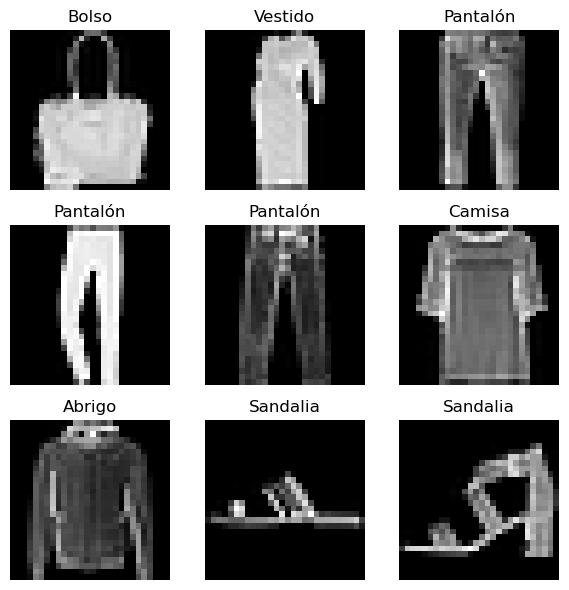

In [6]:
# visualizar un subset de las imágenes
visualize_subset_in_grid(X_train, y_train, subset=9, random=True)

## 1. Preparación de nuestro clasificador (Práctica 5)

Antes de aplicar **PCA** a Fashion-MNIST, a modo de referencia, vamos a crear un <br/>
clasificador Bayesiano "base", tal y como se hizo en la Práctica 5, pero <br/>
particularizándolo a las estadísticas de **Fashion-MNIST**.

Este modelo, entrenado con los datos originales, nos servirá para comparar y comprobar <br/>
la eficacia de **PCA** en la reducción de dimensionalidad.

Primero definimos algunas funciones auxiliares que nos servirán para evaluar los clasificadores...

In [7]:
def evaluar_clasificador(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    do_report=True,
    do_cm=True,
    display_labels=None,
):
    """Evaluación de un clasificador.

    Args:
        clf: Clasificador a evaluar.
        X_train, y_train: Conjunto de entrenamiento.
        X_test, y_test: Conjunto de test.
        do_report: Si True, se muestra el report de clasificación.
        do_cm: Si True, se muestra la matriz de confusión.
        display_labels: Nombres de las clases para mostrar en la matriz de confusión.

    Returns:
        Diccionario con los resultados de la evaluación:
            - Tiempo de entrenamiento.
            - Accuracy en el conjunto de entrenamiento.
            - Accuracy en el conjunto de test.
    """
    # tiempo de entrenamiento
    t0 = perf_counter()
    clf.fit(X_train, y_train)
    t1 = perf_counter()
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    if do_cm:
        # matriz de confusión
        cm_display = ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=display_labels, xticks_rotation=60.0
        )
        cm_display.ax_.set_title(repr(clf))
    if do_report:
        # report de clasificación
        print(
            classification_report(y_test, y_pred, target_names=display_labels, digits=2)
        )
    # recopilamos algunos resultados para reportarlos en otra función.
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred)
    results = {
        "Tiempo train (sec.)": t1 - t0,
        "Acc. (train)": acc_train,
        "Acc. (test)": acc_test,
    }
    return results


def evaluar_clasificadores(clfs, X_train, y_train, X_test, y_test):
    """Evaluación de varios clasificadores."""
    assert iter(clfs), "clfs debe ser un iterable de clasificadores."
    display_labels = list(target_names_esp.values())
    all_results = {}
    name_mlen = 0
    for clf in clfs:
        name = repr(clf)
        print(f"\n{name}:\n{'-' * (len(name) + 1)}")
        all_results[name] = evaluar_clasificador(
            clf, X_train, y_train, X_test, y_test, display_labels=display_labels
        )
        name_mlen = max(name_mlen, len(name))

    # reporte global de precisión y tiempo de entrenamiento
    headers = [f"{'Modelo':<{name_mlen}}"] + [
        f"{k:>{len(k)}}" for k in all_results[name].keys()
    ]
    print("\n" + "  ".join(headers))
    print("-" * len("  ".join(headers)))
    for name, results in all_results.items():
        row = [f"{name:<{name_mlen}}"] + [
            f"{v:>{len(k)}.2f}" for k, v in results.items()
        ]
        print("  ".join(row))
    print()

La siguiente celda es **opcional** ejecutarla. Esta celda, evalúa uno de los clasificadores propuestos <br> 
en la P5, pero sobre los datos de entrenamiento de Fashion-MNIST. 

En esta Práctica 6, **ya aportamos un clasificador por defecto**. Por tanto, no es necesario <br> 
ejecutar esta celda. Solamente la dejamos por reproducibilidad y mayor claridad. <br>

Empleamos LDA por ser más rápido y proporcionar resultados mejores a Bayes ingenuo y QDA.

Evaluando LDA...


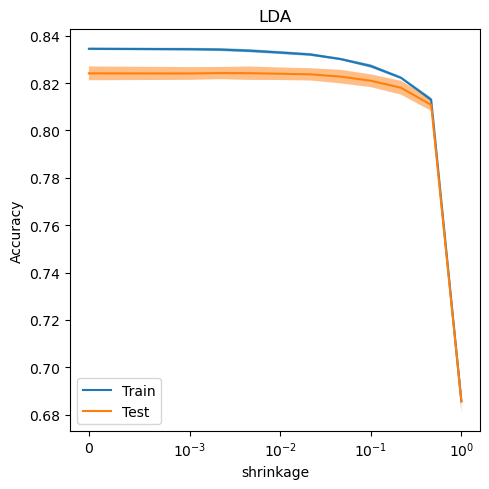

In [8]:
# Configuración para la validación cruzada de cada clasificador.
clasificadores = {
    "LDA": {
        "clf": LinearDiscriminantAnalysis(solver="lsqr"),
        "param_name": "shrinkage",  # (1-shrinkage)*S + (shrinkage*Tr(S)/n)*I_n
        "param_range": np.r_[0.0, np.logspace(-3, 0, 10)],
    }
}

fig, ax = plt.subplots(len(clasificadores), 1, figsize=(5, 5 * len(clasificadores)))
for i, (name, config) in enumerate(clasificadores.items()):
    print(f"Evaluando {name}...")
    ValidationCurveDisplay.from_estimator(
        config["clf"],
        X_train,
        y_train,
        param_name=config["param_name"],
        param_range=config["param_range"],
        scoring="accuracy",
        cv=int(
            len(X_train) / (0.25 * len(X_train))
        ),  # 25% de las imágenes en cada fold
        n_jobs=-1,  # usar todos los cores
        ax=ax,
    )
    ax.set_title(name)
    ax.set_xscale("symlog", linthresh=1e-3)
fig.tight_layout()

Por completitud, añadimos los resultados de test y training para LDA:


LinearDiscriminantAnalysis(shrinkage=0.001, solver='lsqr'):
-----------------------------------------------------------
              precision    recall  f1-score   support

    Camiseta       0.81      0.78      0.79      1000
    Pantalón       1.00      0.93      0.96      1000
      Suéter       0.70      0.68      0.69      1000
     Vestido       0.80      0.84      0.82      1000
      Abrigo       0.70      0.74      0.72      1000
    Sandalia       0.89      0.89      0.89      1000
      Camisa       0.54      0.56      0.55      1000
   Zapatilla       0.88      0.89      0.89      1000
       Bolso       0.93      0.92      0.93      1000
        Bota       0.91      0.91      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.82     10000
weighted avg       0.82      0.81      0.82     10000


Modelo                                                      Tiempo train (sec.)  Acc. (train)  Acc. (test)
------------

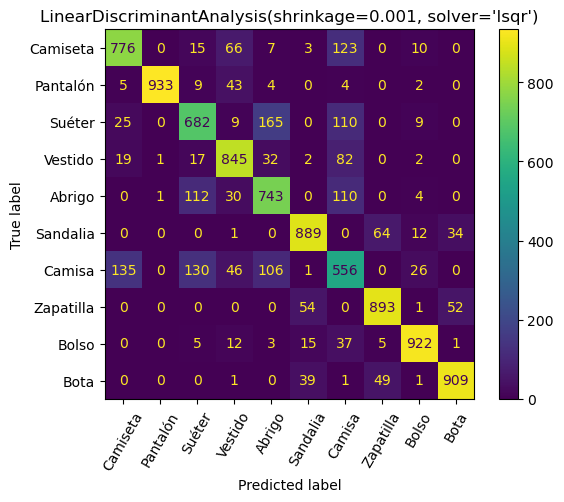

In [9]:
lda = LinearDiscriminantAnalysis(shrinkage=0.001, solver="lsqr")

evaluar_clasificadores([lda], X_train, y_train, X_test, y_test)

La siguiente celda instancia el *clasficador que emplearemos* en el resto de la práctica:

In [10]:
clf = LinearDiscriminantAnalysis(shrinkage=0.001, solver="lsqr")

## 2. Análisis de Componentes Principales (PCA)

Para entender los resultados posteriores, en primer lugar visualiza las (6, por ejemplo) <br> 
componentes **más** y **menos principales**.

Para visualizarlas, te recomendamos emplear la función `visualize_subset_in_grid` <br>
definida anteriormente.

Una vez las visualices, explica por qué crees que dichas componentes principales son así.

In [ ]:
# TODO: tu código

### 2.1 a) ¿Con cuántas de las 784 componentes te puedes quedar sin alterar los resultados de la clasificación?

Para contestar este apartado te recomendamos emplear la función `evaluar_clasificador` <br>
definida anteriormente.

Explica los resultados obtenidos.

In [1]:
# TODO: tu código

### 2.1 b) Si reduces las dimensiones de los datos para mantener el 99% de la variabilidad, ¿qué tan buenos son los resultados de la clasificación?

Comenta los resultados, compara con los obtenidos sin aplicar PCA (ya aportados en este template) <br>
y con los que has obtenido en la pregunta anterior.

In [ ]:
# TODO: tu código

### 2.1 c) Reconstruye alguna imagen del dataset de entrenamiento.

Cualitativamente, podemos comprobar la información retenida por las componentes, <br>
reconstruyendo las imágenes desde el espacio de dimensionalidad reducida, y de forma <br>
cuantitativa, mediante la métrica [***PSNR***](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) (*Peak Signal-to-Noise Ratio*).

Puedes utilizar la función `calculate_psnr`, definida a continuación, para calcular el [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) <br> 
de un conjunto de imágenes reconstruidas respecto a las originales. 

Para comparar visualmente las imágenes reconstruidas, te recomendamos completar la función <br> 
`show_reconstruction_vs_ncomponents`.

In [11]:
def calculate_psnr(imgs, reconstructed_imgs):
    """Peak Signal-to-Noise Ratio (PSNR) para batch de imágenes.

    Args:
        imgs: (n, d) array con n imágenes 28x28.
        reconstructed_imgs: (n, d) array con las imágenes reconstruidas.

    Returns:
        psnr: (n,) array con el PSNR de cada imagen reconstruida.
    """
    mse = np.mean((imgs - reconstructed_imgs) ** 2, axis=1)
    psnr = np.empty_like(mse)
    mask = mse == 0
    psnr[mask] = np.inf
    R2 = 1.0 if imgs.max() <= 1 + 1e-9 else 255**2  # rango de los píxeles
    psnr[~mask] = 10 * np.log10(R2 / mse[~mask])
    return psnr


def show_reconstruction_vs_ncomponents(X, n_components=None, idx=None):
    """Reconstruye y visualiza una imagen a partir de sus componentes principales.

    Esta función debería crear una figura con `nc` subplots, donde `nc` es el número de
    componentes principales a usar para la reconstrucción (ver Args).

    Args:
        X: (n, d) array con n imágenes y dimensión d=28*28=784.
        n_components: (nc,) array con el número de componentes (más) principales a usar
            para la reconstrucción.
            Por ejemplo, `n_components`=[10, 22, 35] correspondería a 3 subplots:
                - subplot 1: reconstrucción usando 10 PCs,
                - subplot 2: reconstrucción usando 22 PCs,
                - subplot 3: reconstrucción usando 35 PCs.
        idx: (int) Índice de la imagen a reconstruir.
    """
    if n_components is None:
        n_components = np.linspace(10, X.shape[1], 5).astype(int)
    if idx is None:
        idx = np.random.choice(len(X))

    # TODO: tu código

Ejemplo de resultado (recuerda completar `show_reconstruction_vs_ncomponents`):

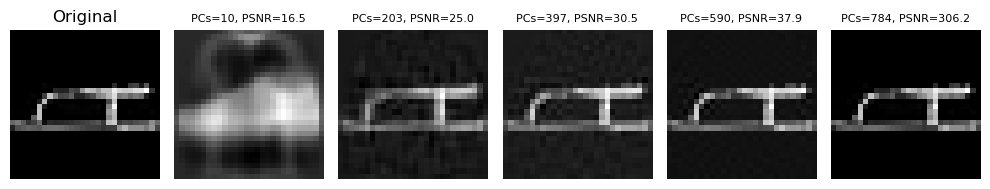

In [15]:
idx = None
n_components = np.linspace(10, X_train.shape[1], 5).astype(int)
show_reconstruction_vs_ncomponents(X_train, n_components, idx)

### 2. Filtrado de ruido en imágenes.

En esta última parte, vamos a analizar la utilidad de PCA para filtrar ruido Gaussiano en imágenes.

In [12]:
def add_noise_to_images(X, noise_std):
    """Añade ruido Gaussiano (centrado en 0) de magnitud `noise_std` a las imágenes ."""
    return np.clip(X + noise_std * np.random.randn(*X.shape), 0, 1)

El siguiente widget visualiza de forma interactiva como afecta el ruido a las imágenes de <br>
Fashion-MNIST, para diferentes valores de `noise_std`:

In [13]:
ncols = 3
subset = np.random.choice(len(X_train), 12, replace=False)
nrows = int(np.ceil(len(subset) / ncols))


@widgets.interact(noise_level=(0, 0.5, 0.01))
def display_images(noise_level=0.3):
    images = X_train[subset]
    images = add_noise_to_images(images, noise_level)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 1.5, nrows * 1.5))
    visualize_subset_in_grid(
        images, y_train[subset], subset=len(subset), fig=fig, ax=ax, random=False
    )
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='noise_level', max=0.5, step=0.01), Output()), _dom_c…

La siguiente celda controla el ruido añadido al dateset mediante `noise_std`:

In [14]:
noise_std = 0.3
X_train_noisy = add_noise_to_images(X_train, noise_std=noise_std)
X_test_noisy = add_noise_to_images(X_test, noise_std=noise_std)

#### 2. a) Utiliza PCA para eliminar el ruido de las imágenes.

En la siguiente celda, visualizamos de forma interactiva el *PSNR* de **todas** las imágenes reconstruidas <br>
con PCA, en función del número de componentes principales indicadas con el slider `n_components`. 

También se visualiza el filtrado de ruido para una imagen de forma interactiva <br> 
(seleccionada con el slider `idx`).

In [19]:
pca_full = PCA()
pca_full.fit(X_train_noisy)
components_full = pca_full.components_  # (n_components, 784)
# reference PSNR values.
psnr_noisy = calculate_psnr(X_train, X_train_noisy)
min_noisy = np.min(psnr_noisy)
max_noisy = np.max(psnr_noisy)


@widgets.interact(n_components=(4, 784, 10), idx=(0, len(X_train_noisy), 1))
def show_reconstruction_vs_ncomponents(n_components=784, idx=0):
    """Visualización interactiva del filtrado de ruido con PCA."""
    # Monkey-patching para evitar calcular de nuevo los componentes principales.
    pca_full.components_ = components_full[:n_components]
    # imágenes filtradas con PCA y sus correspondientes PSNR.
    X_recon = pca_full.inverse_transform(pca_full.transform(X_train_noisy))

    psnr_pca = calculate_psnr(X_train, X_recon)  # (n,)
    binwidth = 0.1
    bins = np.arange(
        min(min_noisy, np.min(psnr_pca)),
        max(max_noisy, np.max(psnr_pca)) + binwidth,
        binwidth,
    )
    # visualización
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    ax[0, 0].imshow(X_train[idx].reshape(28, 28), cmap="gray")
    ax[0, 0].set_title("Original")
    ax[0, 1].imshow(X_train_noisy[idx].reshape(28, 28), cmap="gray")
    ax[0, 1].set_title("Ruidosa")
    ax[1, 0].imshow(X_recon[idx].reshape(28, 28), cmap="gray")
    ax[1, 0].set_title("Filtrada")
    # psnr histograms
    ax[1, 1].hist(psnr_noisy, bins=bins, alpha=0.5, label="Ruidosa")
    ax[1, 1].hist(psnr_pca, bins=bins, alpha=0.5, label="Filtrada")
    ax[1, 1].set_xlabel("PSNR")
    ax[1, 1].legend()
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=784, description='n_components', max=784, min=4, step=10), IntSlider(val…

Modifica los niveles de ruido (`noise_std`) y utiliza el widget para explicar el comportamiento de <br>
PCA.

Para explicarlo, te recomendamos comparar los valores singulares, con y sin ruido (accesibles con el <br>
atributo [`singular_values_`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#:~:text=equal%20to%201.0.-,singular_values_,-ndarray%20of%20shape)) 
o visualizando, para las imágenes ruidosas, la curva con: <br> 
(eje y) error de reconstrucción o PSNR, (eje x) número de componentes empleados en la reconstrucción.

In [ ]:
# TODO: tu código

#### 2. c) Evalúa el clasificador Bayesiano en imágenes de test ruidosas y en el espacio PCA

In [ ]:
# TODO: tu código

Explica de forma razonada los resultados y las decisiones tomadas.

### 2.3. Interpretación visual de PCA $\to$ Visualización 3D

Una forma intersante de interpretar el resultado de PCA es visualizar la localización <br>
de los datos (imágenes de Fashion-MNIST) según las 3 primeras componentes principales <br> 
$PC_1, PC_2, PC_3$.

En primer lugar, importamos algunas librerías adicionales necesarias para la visualización 3D:

In [ ]:
import io

from PIL import Image

# en Google Colab?
try:
    import google.colab  # type:ignore

    IN_COLAB = True
    from IPython.display import HTML, display
except ImportError:
    IN_COLAB = False

# k3d instalado?:
try:
    import k3d
except ImportError as e:
    print("Instalando K3D-jupyter...")
    if IN_COLAB:
        %pip install k3d
        import k3d
    else:
        print(
            "Por favor, instala K3D-jupyter en tu entorno virtual. Por ejemplo (en conda), con:\n"
            "conda install k3d -c conda-forge"
        )
        raise e


Función para visualizar las imágenes en 3D:

In [73]:
def plot_pca_3d(X, n_images, random=False):
    """Función auxiliar para visualizar un subset de imágenes en 3D usando PCA."""
    assert len(X) >= n_images, f"Solo hay {len(X)} imágenes en el dataset."
    pca_3d = PCA(n_components=3)
    pca_3d.fit(X)
    idx = (
        np.random.choice(len(X), n_images, replace=False)
        if random
        else np.arange(n_images)
    )
    subset = X[idx]
    subset_pca = pca_3d.transform(subset)  # (ns, n_components)
    subset_gray = (255 * subset).astype(np.uint8).reshape(-1, 28, 28)
    # transform to PIL images for later conversion to binary
    subset_pil = [Image.fromarray(subset_gray[i], mode="L") for i in range(len(subset))]

    # initialize plot
    plot = k3d.factory.plot(
        grid_visible=False,
        camera_mode="trackball",
        camera_auto_fit=False,
    )

    # add images as textures
    for i, im in enumerate(subset_pil):
        image_bytes = io.BytesIO()
        image_format = "PNG"  # or 'JPEG'
        im.save(image_bytes, format=image_format)
        im_bytes = image_bytes.getvalue()
        plt_texture = k3d.texture(
            im_bytes, file_format="png", translation=subset_pca[i]
        )
        plot += plt_texture

    # add origin coordinate frame
    scale = np.abs(subset_pca).mean()
    plot += k3d.vectors(
        np.zeros((3, 3), dtype=np.float32),
        scale * np.eye(3, dtype=np.float32),
        # [R, R, G, G, B, B]
        colors=[0xFF0000, 0xFF0000, 0x00FF00, 0x00FF00, 0x0000FF, 0x0000FF],
        labels=["X", "Y", "Z"],
        line_width=5e-2,
        head_size=3.0,
    )

    # set camera position
    # fmt:off
    plot.camera = [
        0.0, 0.0, 5.0 * scale, # xyz
        0.0, 0.0, 0.0,
        0.0, -1.0, 0.0,
    ]
    # fmt:on
    if IN_COLAB:
        plot.snapshot_type = "inline"
        display(HTML(plot.get_snapshot()))
    else:
        plot.display()
    return plot

¿Qué determina la ubicación de las imágenes en 3D?

¿Qué efecto tiene PCA en la distribución de las imágenes de la siguiente visualización?

¿Se observa el mismo tipo de distribución si se emplean las imágenes ruidosas? ¿Por qué?

<div class="alert alert-block alert-info">
🛈 Al ejecutar por primera vez la siguiente celda, es posible que aparezca el Warning: <br>
<em>"Widgets require us to install supporting files from a 3rd party website"</em><br>
En ese caso Presiona "Ok"
</div>

In [74]:
plot = plot_pca_3d(X_train, 100, random=False)

Output()